# CV Paper : 2. GoogleNet

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np

> PyTorch에서 신경망 모델은 nn.Module 을 상속받는 클래스(class)를 생성하여 정의합니다. \
> __init__ 함수에서 신경망의 계층(layer)들을 정의하고, \
> forward 함수에서 신경망에 데이터를 어떻게 전달할지 지정합니다. \
> 가능한 경우 GPU 또는 MPS로 신경망을 이동시켜 연산을 가속(accelerate)합니다.


## Architecture

In [2]:
class Inception(nn.Module):
    def __init__(self, in_channels, n1x1, red3x3, n3x3, red5x5, n5x5, pool_prj):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_channels, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_channels, red3x3, kernel_size=1),
            nn.BatchNorm2d(red3x3),
            nn.ReLU(True),
            nn.Conv2d(red3x3, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_channels, red5x5, kernel_size=1),
            nn.BatchNorm2d(red5x5),
            nn.ReLU(True),
            nn.Conv2d(red5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_prj, kernel_size=1),
            nn.BatchNorm2d(pool_prj),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)


class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [4]:
# 학습에 사용할 CPU나 GPU, MPS 장치를 얻습니다
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using '{device}' device")

# 모델 정의
model = GoogLeNet().to(device)

Using 'cuda' device


In [5]:
# 성공적으로 모델이 구축됬는지 확인합니다.
dummy_x = torch.randn(3, 3, 32, 32).to(device)
output = model(dummy_x)
print(output)

tensor([[ 3.8679e-02, -2.7870e-01, -6.6495e-02,  2.2772e-01, -1.9992e-04,
         -3.4557e-01, -3.1901e-01,  2.7882e-01, -3.2892e-01, -1.7208e-01],
        [-3.2420e-01, -2.5801e-01,  5.0108e-02,  1.1239e-01, -1.8469e-01,
         -3.0958e-01, -3.9858e-01,  2.2633e-01, -3.2074e-01, -1.4856e-01],
        [ 1.3790e-02, -4.3767e-01, -1.3096e-01,  4.2471e-01, -2.8498e-01,
         -1.5611e-01, -2.1650e-01,  1.8155e-01, -4.1590e-01, -1.8729e-01]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [12]:
from torchinfo import summary

# 모델 요약 정보 출력
summary(model, input_size=(3, 3, 32, 32), device=device.type)

Layer (type:depth-idx)                   Output Shape              Param #
GoogLeNet                                [3, 10]                   --
├─Sequential: 1-1                        [3, 192, 32, 32]          --
│    └─Conv2d: 2-1                       [3, 192, 32, 32]          5,376
│    └─BatchNorm2d: 2-2                  [3, 192, 32, 32]          384
│    └─ReLU: 2-3                         [3, 192, 32, 32]          --
├─Inception: 1-2                         [3, 256, 32, 32]          --
│    └─Sequential: 2-4                   [3, 64, 32, 32]           --
│    │    └─Conv2d: 3-1                  [3, 64, 32, 32]           12,352
│    │    └─BatchNorm2d: 3-2             [3, 64, 32, 32]           128
│    │    └─ReLU: 3-3                    [3, 64, 32, 32]           --
│    └─Sequential: 2-5                   [3, 128, 32, 32]          --
│    │    └─Conv2d: 3-4                  [3, 96, 32, 32]           18,528
│    │    └─BatchNorm2d: 3-5             [3, 96, 32, 32]           192
│

## Hyperparameters

In [13]:
learning_rate = 0.0001
epochs = 10
batch_size = 32

## DataLoad

### Data : CIPAR10

> ***CIFAR10*** \
> 50,000개의 Train Data와 10,000의 Test Data로 구성. \
> 각 데이터는 10개의 클래스 중 하나에 해당한다. \
> 그리고 각 데이터의 크기는 가로 32, 세로 32의 채널 3으로 이루어져 있다. \
> CIFAR10 데이터셋은 torchvision 라이브러리에 내장.

> 파이토치(PyTorch)에는 데이터 작업을 위한 기본 요소 두가지인 \
> torch.utils.data.DataLoader 와 torch.utils.data.Dataset 가 있습니다. \
> Dataset 은 샘플과 정답(label)을 저장하고, \
> DataLoader 는 Dataset 을 순회 가능한 객체(iterable)로 감쌉니다.

In [14]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

cifar10_data = CIFAR10(root='data', train=False, download=True, transform=transforms.ToTensor())
cifar10_classes = ["airplane",
                   "automobile",
                   "bird",
                   "Cat",
                   "deer",
                   "dog",
                   "frog" ,
                   "horse",
                   "Ship",
                   "truck"]

Files already downloaded and verified


### Data preview

데이터의 수:  10000


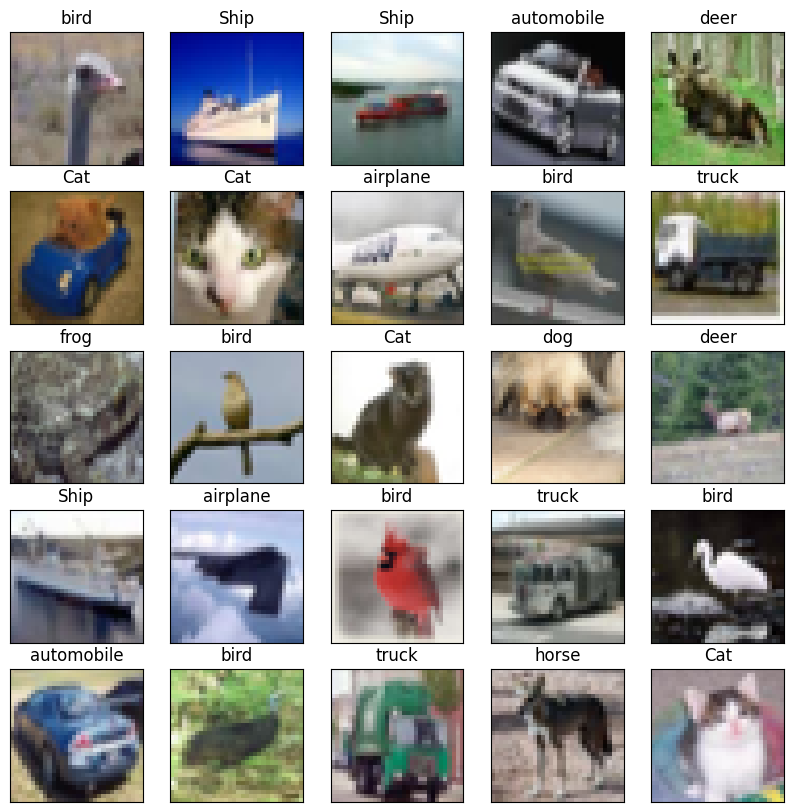

In [15]:
print("데이터의 수: ", len(cifar10_data))

n_image = 25  # 표시하는 이미지의 수
cifar10_loader = DataLoader(cifar10_data, batch_size=n_image, shuffle=True)
dataiter = iter(cifar10_loader)  # iteratior: 요소를 차례대로 꺼낼 수 있게 한다.
images, labels = next(dataiter)  # 처음의 배치를 꺼낸다

plt.figure(figsize=(10, 10))  # 이미지 크기
for i in range(n_image):
    ax = plt.subplot(5, 5, i+1)
    ax.imshow(images[i].permute(1, 2, 0))
    label = cifar10_classes[labels[i]]
    ax.set_title(label)
    ax.get_xaxis().set_visible(False) # 축을 표시하지 않는다
    ax.get_yaxis().set_visible(False)
plt.show()

### Data Augmentation

In [16]:
# None

### Set DataLoader 

In [17]:
# 데이터 불러오기 
train_data = CIFAR10(root="data", train=True, download=True, transform=transforms.ToTensor())   
test_data = CIFAR10(root="data",train=False,download=True,transform=transforms.ToTensor())

# DataLoader 설정
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
print("------------------------------------------")
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Files already downloaded and verified
Files already downloaded and verified
------------------------------------------
Shape of X [N, C, H, W]: torch.Size([32, 3, 32, 32])
Shape of y: torch.Size([32]) torch.int64


## Optimizer Setting

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

### ( Train option 1 )

#### 학습 전 유요한 함수 3가지 선언

In [19]:
# 학습 중간에 accuracy의 값이 어떻게 변하는지를 시각화 해주는 acc_plot 함수를 구현
def acc_plot(acc):
    plt.plot(acc)
    plt.xlabel('log')
    plt.ylabel('accuracy')
    plt.grid(True)
    plt.show()
    return 0

# 학습이 시작한 후 시간이 얼마나 흘렀는지를 확인할 수 있는 Timer 클래스를 구현한다.
import time
import datetime
class Timer():
    def __init__(self):
        self.cur_t = time.time()

    def tic(self):
        self.cur_t = time.time()

    def toc(self):
        return time.time() - self.cur_t

    def tocStr(self, t=-1):
        if (t == -1):
            return str(datetime.timedelta(seconds=np.round(time.time() - self.cur_t, 3)))[:-4]
        else:
            return str(datetime.timedelta(seconds=np.round(t, 3)))[:-4]
        
# 테스트 데이터로 모델의 일반화 성능을 측정하기 위한 함수를 구현한다.
def test_on_cifar10(model, accuracy_list):
    model.eval()  # eval 모드로 변경 (Batch Normalization이 moving mean/var를 사용하도록, dropout을 적용하지 않도록 설정)
    correct = 0
    total = 0
    for j, (images, labels) in enumerate(test_loader):
        images = torch.tensor(images).to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()
        if (j+1)%100==0:
            break

    print('Test Accuracy of the model on the 100 test images: %d %%' % (100 * correct / total))
    accuracy_list.append(100 * correct / total)
    return accuracy_list

Epoch [1/10], Iter [100/1562] Loss: 1.5572, iter_time: 10.88


/tmp/ipykernel_218692/315268134.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(device)


Test Accuracy of the model on the 100 test images: 38 %
Epoch [1/10], Iter [200/1562] Loss: 1.6926, iter_time: 17.49
Test Accuracy of the model on the 100 test images: 34 %
Epoch [1/10], Iter [300/1562] Loss: 1.6612, iter_time: 17.43
Test Accuracy of the model on the 100 test images: 34 %
Epoch [1/10], Iter [400/1562] Loss: 1.5717, iter_time: 17.92
Test Accuracy of the model on the 100 test images: 40 %
Epoch [1/10], Iter [500/1562] Loss: 1.7240, iter_time: 18.13
Test Accuracy of the model on the 100 test images: 44 %
Epoch [1/10], Iter [600/1562] Loss: 1.4236, iter_time: 18.09
Test Accuracy of the model on the 100 test images: 48 %
Epoch [1/10], Iter [700/1562] Loss: 1.4218, iter_time: 18.31
Test Accuracy of the model on the 100 test images: 47 %
Epoch [1/10], Iter [800/1562] Loss: 1.2793, iter_time: 19.07
Test Accuracy of the model on the 100 test images: 47 %
Epoch [1/10], Iter [900/1562] Loss: 1.2564, iter_time: 18.10
Test Accuracy of the model on the 100 test images: 52 %
Epoch [1

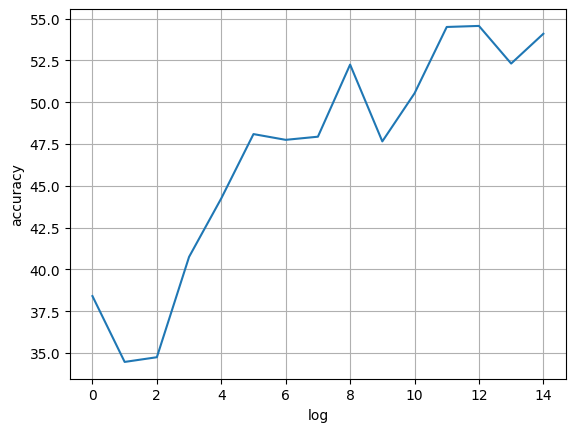

Epoch [2/10], Iter [100/1562] Loss: 1.0314, iter_time: 26.21
Test Accuracy of the model on the 100 test images: 56 %
Epoch [2/10], Iter [200/1562] Loss: 1.5771, iter_time: 19.13
Test Accuracy of the model on the 100 test images: 56 %
Epoch [2/10], Iter [300/1562] Loss: 0.7767, iter_time: 18.58
Test Accuracy of the model on the 100 test images: 57 %
Epoch [2/10], Iter [400/1562] Loss: 1.0775, iter_time: 18.42
Test Accuracy of the model on the 100 test images: 59 %
Epoch [2/10], Iter [500/1562] Loss: 0.9634, iter_time: 18.79
Test Accuracy of the model on the 100 test images: 60 %
Epoch [2/10], Iter [600/1562] Loss: 0.6547, iter_time: 18.50
Test Accuracy of the model on the 100 test images: 64 %
Epoch [2/10], Iter [700/1562] Loss: 1.0675, iter_time: 18.38
Test Accuracy of the model on the 100 test images: 62 %
Epoch [2/10], Iter [800/1562] Loss: 0.8144, iter_time: 18.80
Test Accuracy of the model on the 100 test images: 63 %
Epoch [2/10], Iter [900/1562] Loss: 1.1719, iter_time: 18.82
Tes

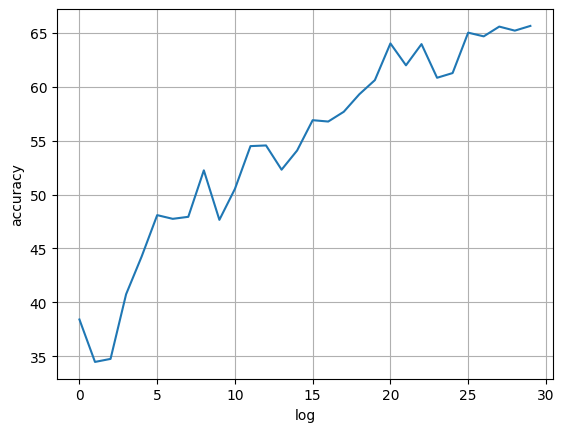

Epoch [3/10], Iter [100/1562] Loss: 0.8680, iter_time: 25.71
Test Accuracy of the model on the 100 test images: 69 %
Epoch [3/10], Iter [200/1562] Loss: 1.1256, iter_time: 18.34
Test Accuracy of the model on the 100 test images: 61 %
Epoch [3/10], Iter [300/1562] Loss: 0.9485, iter_time: 18.68
Test Accuracy of the model on the 100 test images: 64 %
Epoch [3/10], Iter [400/1562] Loss: 0.5849, iter_time: 18.92
Test Accuracy of the model on the 100 test images: 69 %
Epoch [3/10], Iter [500/1562] Loss: 0.8153, iter_time: 18.77
Test Accuracy of the model on the 100 test images: 69 %
Epoch [3/10], Iter [600/1562] Loss: 1.1824, iter_time: 18.62
Test Accuracy of the model on the 100 test images: 68 %
Epoch [3/10], Iter [700/1562] Loss: 0.5074, iter_time: 18.27
Test Accuracy of the model on the 100 test images: 67 %
Epoch [3/10], Iter [800/1562] Loss: 0.7570, iter_time: 18.39
Test Accuracy of the model on the 100 test images: 70 %
Epoch [3/10], Iter [900/1562] Loss: 1.2153, iter_time: 18.70
Tes

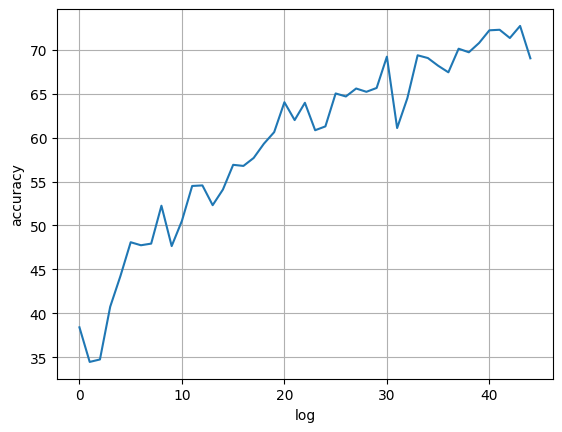

Epoch [4/10], Iter [100/1562] Loss: 0.7848, iter_time: 25.49
Test Accuracy of the model on the 100 test images: 73 %
Epoch [4/10], Iter [200/1562] Loss: 0.8272, iter_time: 18.47
Test Accuracy of the model on the 100 test images: 67 %
Epoch [4/10], Iter [300/1562] Loss: 0.9677, iter_time: 18.46
Test Accuracy of the model on the 100 test images: 73 %
Epoch [4/10], Iter [400/1562] Loss: 0.5977, iter_time: 18.21
Test Accuracy of the model on the 100 test images: 74 %
Epoch [4/10], Iter [500/1562] Loss: 1.1020, iter_time: 18.23
Test Accuracy of the model on the 100 test images: 74 %
Epoch [4/10], Iter [600/1562] Loss: 0.8863, iter_time: 18.39
Test Accuracy of the model on the 100 test images: 72 %
Epoch [4/10], Iter [700/1562] Loss: 0.9468, iter_time: 18.57
Test Accuracy of the model on the 100 test images: 74 %
Epoch [4/10], Iter [800/1562] Loss: 0.8621, iter_time: 18.21
Test Accuracy of the model on the 100 test images: 73 %
Epoch [4/10], Iter [900/1562] Loss: 0.4453, iter_time: 18.40
Tes

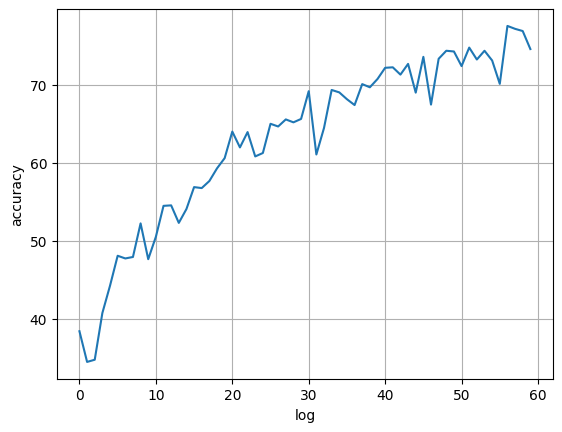

Epoch [5/10], Iter [100/1562] Loss: 0.6964, iter_time: 25.81
Test Accuracy of the model on the 100 test images: 78 %
Epoch [5/10], Iter [200/1562] Loss: 0.5252, iter_time: 18.56
Test Accuracy of the model on the 100 test images: 75 %
Epoch [5/10], Iter [300/1562] Loss: 0.9106, iter_time: 18.48
Test Accuracy of the model on the 100 test images: 74 %
Epoch [5/10], Iter [400/1562] Loss: 0.3255, iter_time: 18.37
Test Accuracy of the model on the 100 test images: 77 %
Epoch [5/10], Iter [500/1562] Loss: 0.6683, iter_time: 18.60
Test Accuracy of the model on the 100 test images: 73 %
Epoch [5/10], Iter [600/1562] Loss: 0.6885, iter_time: 18.99
Test Accuracy of the model on the 100 test images: 78 %
Epoch [5/10], Iter [700/1562] Loss: 0.5106, iter_time: 18.71
Test Accuracy of the model on the 100 test images: 75 %
Epoch [5/10], Iter [800/1562] Loss: 0.4077, iter_time: 19.02
Test Accuracy of the model on the 100 test images: 76 %
Epoch [5/10], Iter [900/1562] Loss: 0.6486, iter_time: 18.91
Tes

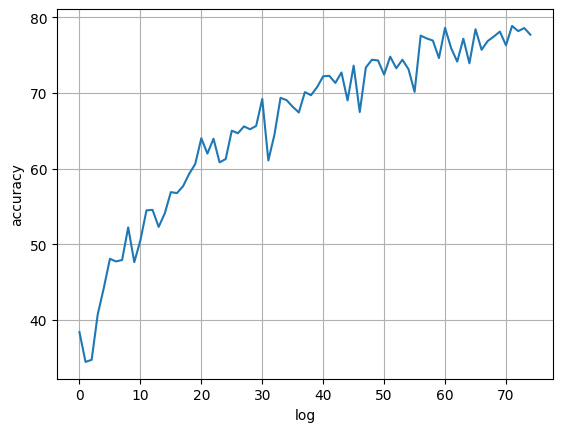

Epoch [6/10], Iter [100/1562] Loss: 0.6391, iter_time: 25.58
Test Accuracy of the model on the 100 test images: 79 %
Epoch [6/10], Iter [200/1562] Loss: 0.6154, iter_time: 19.15
Test Accuracy of the model on the 100 test images: 79 %
Epoch [6/10], Iter [300/1562] Loss: 0.5856, iter_time: 18.69
Test Accuracy of the model on the 100 test images: 79 %
Epoch [6/10], Iter [400/1562] Loss: 0.4341, iter_time: 19.10
Test Accuracy of the model on the 100 test images: 77 %
Epoch [6/10], Iter [500/1562] Loss: 0.6527, iter_time: 18.70
Test Accuracy of the model on the 100 test images: 78 %
Epoch [6/10], Iter [600/1562] Loss: 0.6365, iter_time: 19.09
Test Accuracy of the model on the 100 test images: 79 %
Epoch [6/10], Iter [700/1562] Loss: 0.6031, iter_time: 18.91
Test Accuracy of the model on the 100 test images: 78 %
Epoch [6/10], Iter [800/1562] Loss: 0.4607, iter_time: 18.61
Test Accuracy of the model on the 100 test images: 78 %
Epoch [6/10], Iter [900/1562] Loss: 0.2597, iter_time: 18.48
Tes

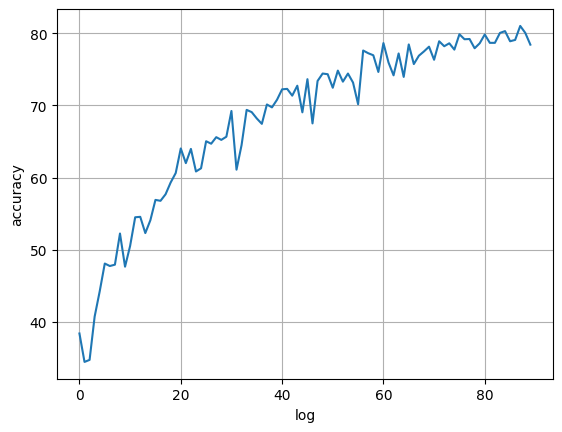

Epoch [7/10], Iter [100/1562] Loss: 0.4732, iter_time: 27.00
Test Accuracy of the model on the 100 test images: 82 %
Epoch [7/10], Iter [200/1562] Loss: 0.3502, iter_time: 18.96
Test Accuracy of the model on the 100 test images: 80 %
Epoch [7/10], Iter [300/1562] Loss: 0.3222, iter_time: 19.18
Test Accuracy of the model on the 100 test images: 80 %
Epoch [7/10], Iter [400/1562] Loss: 0.4235, iter_time: 18.97
Test Accuracy of the model on the 100 test images: 80 %
Epoch [7/10], Iter [500/1562] Loss: 0.3118, iter_time: 19.49
Test Accuracy of the model on the 100 test images: 79 %
Epoch [7/10], Iter [600/1562] Loss: 0.2887, iter_time: 18.82
Test Accuracy of the model on the 100 test images: 80 %
Epoch [7/10], Iter [700/1562] Loss: 0.3614, iter_time: 19.79
Test Accuracy of the model on the 100 test images: 81 %
Epoch [7/10], Iter [800/1562] Loss: 0.5248, iter_time: 17.76
Test Accuracy of the model on the 100 test images: 80 %
Epoch [7/10], Iter [900/1562] Loss: 0.3213, iter_time: 18.77
Tes

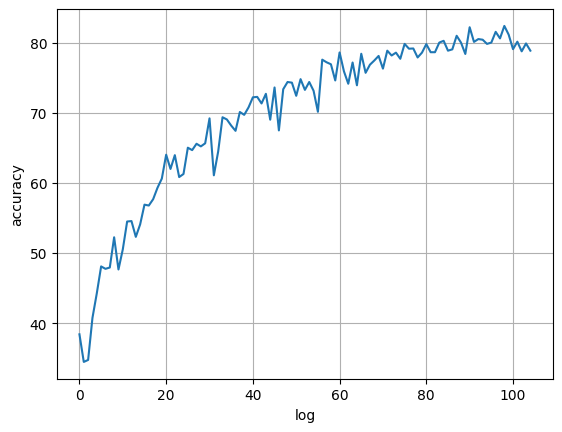

Epoch [8/10], Iter [100/1562] Loss: 0.5927, iter_time: 25.50
Test Accuracy of the model on the 100 test images: 83 %
Epoch [8/10], Iter [200/1562] Loss: 0.7229, iter_time: 19.05
Test Accuracy of the model on the 100 test images: 82 %
Epoch [8/10], Iter [300/1562] Loss: 0.4741, iter_time: 19.69
Test Accuracy of the model on the 100 test images: 81 %
Epoch [8/10], Iter [400/1562] Loss: 0.3756, iter_time: 18.88
Test Accuracy of the model on the 100 test images: 83 %
Epoch [8/10], Iter [500/1562] Loss: 0.4988, iter_time: 18.69
Test Accuracy of the model on the 100 test images: 81 %
Epoch [8/10], Iter [600/1562] Loss: 0.4059, iter_time: 18.41
Test Accuracy of the model on the 100 test images: 82 %
Epoch [8/10], Iter [700/1562] Loss: 0.5270, iter_time: 18.99
Test Accuracy of the model on the 100 test images: 83 %
Epoch [8/10], Iter [800/1562] Loss: 0.2531, iter_time: 18.36
Test Accuracy of the model on the 100 test images: 83 %
Epoch [8/10], Iter [900/1562] Loss: 0.5275, iter_time: 18.77
Tes

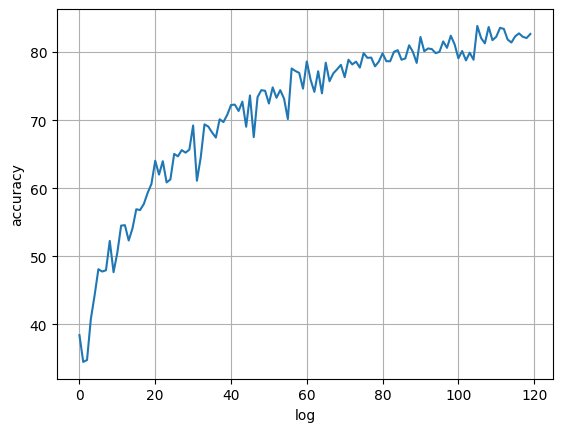

Epoch [9/10], Iter [100/1562] Loss: 0.2537, iter_time: 25.46
Test Accuracy of the model on the 100 test images: 83 %
Epoch [9/10], Iter [200/1562] Loss: 0.2571, iter_time: 19.43
Test Accuracy of the model on the 100 test images: 83 %
Epoch [9/10], Iter [300/1562] Loss: 0.9080, iter_time: 18.84
Test Accuracy of the model on the 100 test images: 81 %
Epoch [9/10], Iter [400/1562] Loss: 0.5991, iter_time: 18.69
Test Accuracy of the model on the 100 test images: 82 %
Epoch [9/10], Iter [500/1562] Loss: 0.4508, iter_time: 18.25
Test Accuracy of the model on the 100 test images: 82 %
Epoch [9/10], Iter [600/1562] Loss: 0.4618, iter_time: 18.86
Test Accuracy of the model on the 100 test images: 84 %
Epoch [9/10], Iter [700/1562] Loss: 0.5057, iter_time: 19.19
Test Accuracy of the model on the 100 test images: 81 %
Epoch [9/10], Iter [800/1562] Loss: 0.6734, iter_time: 19.49
Test Accuracy of the model on the 100 test images: 84 %
Epoch [9/10], Iter [900/1562] Loss: 0.2909, iter_time: 18.78
Tes

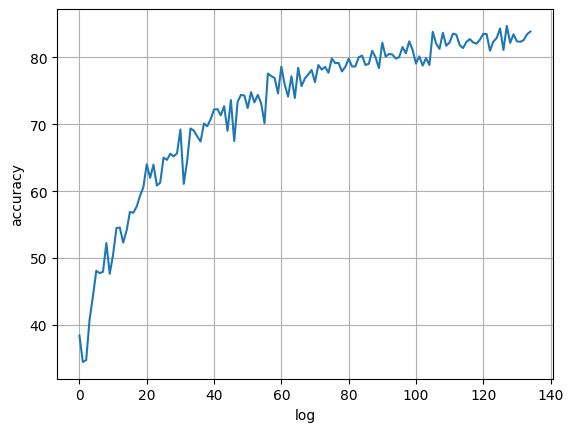

Epoch [10/10], Iter [100/1562] Loss: 0.3067, iter_time: 26.33
Test Accuracy of the model on the 100 test images: 84 %
Epoch [10/10], Iter [200/1562] Loss: 0.3217, iter_time: 18.42
Test Accuracy of the model on the 100 test images: 79 %
Epoch [10/10], Iter [300/1562] Loss: 0.2676, iter_time: 18.88
Test Accuracy of the model on the 100 test images: 84 %
Epoch [10/10], Iter [400/1562] Loss: 0.2371, iter_time: 18.75
Test Accuracy of the model on the 100 test images: 83 %
Epoch [10/10], Iter [500/1562] Loss: 0.3635, iter_time: 18.33
Test Accuracy of the model on the 100 test images: 80 %
Epoch [10/10], Iter [600/1562] Loss: 0.2794, iter_time: 18.58
Test Accuracy of the model on the 100 test images: 84 %
Epoch [10/10], Iter [700/1562] Loss: 0.2233, iter_time: 19.08
Test Accuracy of the model on the 100 test images: 82 %
Epoch [10/10], Iter [800/1562] Loss: 0.2761, iter_time: 19.38
Test Accuracy of the model on the 100 test images: 83 %
Epoch [10/10], Iter [900/1562] Loss: 0.4599, iter_time: 

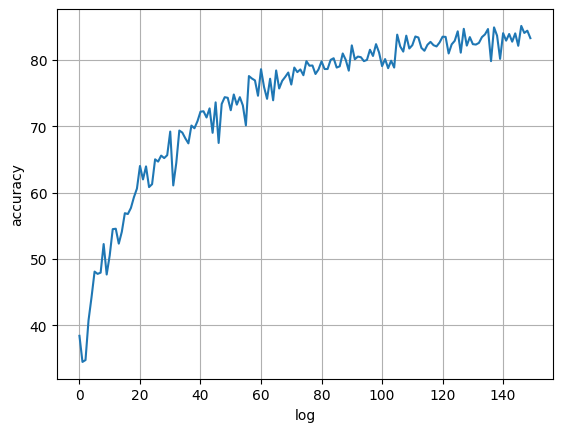

In [20]:
tell_time = Timer()
iter_time = 0

accuracy_list = []
for epoch in range(epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, iter_time: %2.2f'
                 %(epoch+1, epochs, i+1, len(train_data)//batch_size, loss.item(), tell_time.toc()-iter_time))
            iter_time = tell_time.toc()
            accuracy_list = test_on_cifar10(model, accuracy_list)

    acc_plot(accuracy_list)

### ( Train option 2 )

In [23]:
record_loss_train = []
record_loss_test = []

# Training 학습
for epoch in range(epochs): 
    model.train()
    loss_train = 0
    for j, (image, label) in enumerate(train_loader):
        image, label = image.cuda(), label.cuda()
        pred = model(image)
        loss = criterion(pred, label)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    model.eval() # Mode of Evaluation
    loss_test = 0
    for j, (image, label) in enumerate(test_loader): # mini_batch(x, t)를 꺼낸다.
        image, label = image.cuda(), label.cuda()
        pred = model(image)
        loss = criterion(pred, label)
        loss_test += loss.item()
    loss_test /= j+1
    record_loss_test.append(loss_test)

    if epoch%1 == 0:
        print("Epoch:", epoch+1,
              "\n",
              "Loss_train:", loss_train,
              "\n",
              "loss_test:", loss_test,)

print("------------------------------------\n",
      "---------- Training Done  ----------")

Epoch: 1 
 Loss_train: 0.3176187293834017 
 loss_test: 0.3976704871026091
Epoch: 2 
 Loss_train: 0.26403751586440544 
 loss_test: 0.40307812487926725
Epoch: 3 
 Loss_train: 0.2109907743671786 
 loss_test: 0.4188271877817072
Epoch: 4 
 Loss_train: 0.17083374519253855 
 loss_test: 0.39729066891744497
Epoch: 5 
 Loss_train: 0.13213732059459873 
 loss_test: 0.42386243762537695
Epoch: 6 
 Loss_train: 0.1097684451155436 
 loss_test: 0.3999347950870427
Epoch: 7 
 Loss_train: 0.09414601862162139 
 loss_test: 0.4021610642512576
Epoch: 8 
 Loss_train: 0.07574356879853665 
 loss_test: 0.4712336100399875
Epoch: 9 
 Loss_train: 0.07387024323777454 
 loss_test: 0.46384190871549874
Epoch: 10 
 Loss_train: 0.06622775648666936 
 loss_test: 0.4313496202379227
------------------------------------
 ---------- Training Done  ----------


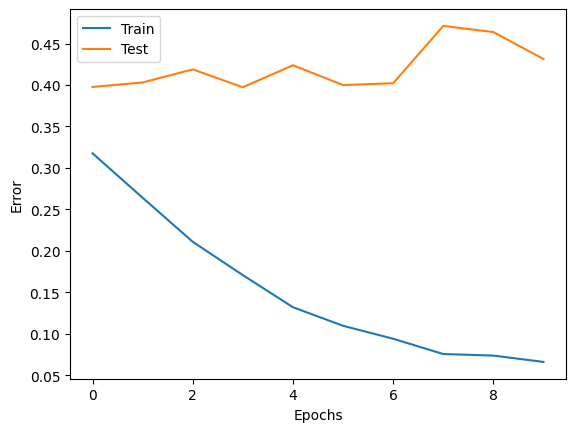

In [24]:
# 오차 추이
plt.plot(range(len(record_loss_train)), record_loss_train,label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

### ( Train option 3 )

In [69]:
# 각 학습단계(training loop)에서 모델은(배치 batch로 제공되는) 학습데이터셋에 대한 예측을 수행,
# 예측 오류를 역전파하여 모델의 매개변수를 조정합니다.

def train(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    loss_t = 0  # 추가
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측(prediction)과 손실(loss) 계산
        pred = model(X)
        loss = criterion(pred, y)

        loss_t += loss.item()  # 추가

        # BackPropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X) 
            print(f"loss {loss:>7f} [{current:>5d}/{size:>5d}]")
    
    loss_t /= batch + 1  # 추가
    record_loss_train.append(loss_t) # 추가


# 모델이 학습하고 있는지를 확인하기 위해 테스트 데이터셋으로 모델의 성능을 확인합니다.
def test(dataloader, model, criterion):
    test_loss = 0  # 추가
    size = len(dataloader.dataset)
    num_batchs = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        record_loss_test.append(test_loss)
    
    test_loss /= num_batchs
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
for i in range(epochs):
    print(f"Epoch {i+1}\n------------------------------------------")
    
    train(train_loader, model, criterion, optimizer)
    test(test_loader, model, criterion)

print("------------------------- \n"
      "----- Training Done -----")

In [ ]:
# 오차 추이
plt.plot(range(len(record_loss_train)), record_loss_train,label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

### Accuracy 정답률

In [26]:
# 정답률
correct = 0
total = 0
model.eval()  # eval mode
for i, (image, label) in enumerate(test_loader):
    image, label = image.cuda(), label.cuda()
    pred = model(image)
    correct += (pred.argmax(1) == label).sum().item()
    total += len(image)

print(f"정답률: {correct/total*100}%   __by {epochs} epochs")

정답률: 88.53%   __by 10 epochs
